# Comprehensive Case Study – Crime Case 

In [198]:
import pandas as pd
import numpy as np
import calendar
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from scipy.stats import randint

In [200]:
# Load datasets
crime = pd.read_csv('crime_dataset.csv')
weapon_types = pd.read_csv('weapon_types.csv')
crime_types = pd.read_csv('crime_types.csv')

# Display first few rows
print("Crime Dataset Head:")
display(crime.head())
print("Weapon Types Head:")
display(weapon_types.head())
print("Crime Types Head:")
display(crime_types.head())

# Basic info
print("\nCrime Dataset Info:")
crime.info()
print("\nWeapon Types Dataset Info:")
weapon_types.info()
print("\nCrime Types Dataset Info:")
crime_types.info()

Crime Dataset Head:


,division_number,date_reported,date_occurred,area,area_name,reporting_district,part,crime_code,modus_operandi,victim_age,...,crime_code_1,crime_code_2,crime_code_3,crime_code_4,incident_admincode,location,cross_street,latitude,longitude,case_solved
0,211414090,2021-06-27,2021-06-20 20:00:00,14,Pacific,1464,1,480,0344,32.0,...,480.0,NaN,NaN,NaN,0,12400 FIELDING,NaN,33.9791,-118.4092,Not solved
1,210504861,2021-01-22,2021-01-21 22:00:00,5,Harbor,515,1,510,NaN,0.0,...,510.0,NaN,NaN,NaN,1,1500 BAY VIEW AV,NaN,33.7929,-118.2710,Solved
2,210104843,2021-01-21,2021-01-21 02:00:00,1,Central,139,1,510,NaN,0.0,...,510.0,NaN,NaN,NaN,1,300 S SANTA FE AV,NaN,34.0420,-118.2326,Solved
3,210115564,2021-08-22,2021-08-22 07:00:00,1,Central,151,1,350,1308 0344 0345 1822,29.0,...,350.0,NaN,NaN,NaN,0,7TH,FIGUEROA,34.0496,-118.2603,Not solved
4,211421187,2021-11-09,2021-11-07 19:00:00,14,Pacific,1465,1,510,NaN,0.0,...,510.0,NaN,NaN,NaN,0,5500 MESMER AV,NaN,33.9869,-118.4022,Not solved


Weapon Types Head:


,weapon_code,weapon_description
0,400,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)"
1,500,UNKNOWN WEAPON/OTHER WEAPON
2,102,HAND GUN
3,201,KNIFE WITH BLADE OVER 6 INCHES IN LENGTH
4,107,OTHER FIREARM


Crime Types Head:


,crime_code,crime_description
0,480,BIKE - STOLEN
1,510,VEHICLE - STOLEN
2,350,"THEFT, PERSON"
3,440,THEFT PLAIN - PETTY ($950 & UNDER)
4,420,THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)



Crime Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203089 entries, 0 to 203088
Data columns (total 25 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   division_number      203089 non-null  int64  
 1   date_reported        203089 non-null  object 
 2   date_occurred        203089 non-null  object 
 3   area                 203089 non-null  int64  
 4   area_name            203089 non-null  object 
 5   reporting_district   203089 non-null  int64  
 6   part                 203089 non-null  int64  
 7   crime_code           203089 non-null  int64  
 8   modus_operandi       174160 non-null  object 
 9   victim_age           199027 non-null  float64
 10  victim_gender        175360 non-null  object 
 11  victim_ethnicity     175358 non-null  object 
 12  premise_code         203086 non-null  float64
 13  premise_description  202997 non-null  object 
 14  weapon_code          71246 non-null   float64
 

## 1. Data Cleaning

- Identify and handle missing values

In [204]:
crime.isnull().sum()

division_number             0
date_reported               0
date_occurred               0
area                        0
area_name                   0
reporting_district          0
part                        0
crime_code                  0
modus_operandi          28929
victim_age               4062
victim_gender           27729
victim_ethnicity        27731
premise_code                3
premise_description        92
weapon_code            131843
crime_code_1                2
crime_code_2           187239
crime_code_3           202560
crime_code_4           203071
incident_admincode          0
location                    0
cross_street           167414
latitude                    0
longitude                   0
case_solved                 0
dtype: int64

In [206]:
crime.describe()

,division_number,area,reporting_district,part,crime_code,victim_age,premise_code,weapon_code,crime_code_1,crime_code_2,crime_code_3,crime_code_4,incident_admincode,latitude,longitude
count,2.030890e+05,203089.000000,203089.000000,203089.000000,203089.000000,199027.000000,203086.000000,71246.000000,203087.000000,15850.000000,529.000000,18.000000,203089.000000,203089.000000,203089.000000
mean,2.111349e+08,10.751075,1121.524189,1.405118,504.364879,29.963553,297.406266,358.930943,504.101818,956.582397,978.476371,993.166667,0.214556,33.826701,-117.499034
std,1.048451e+06,6.061707,606.272483,0.490916,209.716701,21.651435,216.205401,125.633107,209.525038,114.039063,62.925761,20.756997,0.410515,2.888534,10.026599
min,2.113000e+03,1.000000,101.000000,1.000000,110.000000,0.000000,101.000000,101.000000,110.000000,210.000000,434.000000,910.000000,0.000000,0.000000,-118.667300
25%,2.106060e+08,6.000000,628.000000,1.000000,330.000000,12.000000,101.000000,307.000000,330.000000,998.000000,998.000000,998.000000,0.000000,34.011100,-118.429100
50%,2.111112e+08,11.000000,1144.000000,1.000000,480.000000,31.000000,203.000000,400.000000,480.000000,998.000000,998.000000,998.000000,0.000000,34.058100,-118.322500
75%,2.116065e+08,16.000000,1612.000000,2.000000,626.000000,45.000000,501.000000,400.000000,626.000000,998.000000,998.000000,998.000000,0.000000,34.161100,-118.274100
max,2.315056e+08,21.000000,2199.000000,2.000000,956.000000,99.000000,971.000000,516.000000,956.000000,999.000000,999.000000,999.000000,1.000000,34.334300,0.000000


In [208]:
print(crime.shape)

(203089, 25)


- Remove or review duplicates and inconsistencies

In [211]:
# Replacing Missing Weapon Codes with -1 to Preserve Numeric Data Type
crime['weapon_code'] = crime['weapon_code'].fillna(-1)

In [213]:
#Counts the number of values in the victim_age column
count = crime['victim_age'].value_counts()
print(count)

victim_age
0.0     48488
30.0     4518
35.0     4456
29.0     4395
28.0     4373
        ...  
93.0       25
98.0       18
95.0       17
96.0       13
97.0       10
Name: count, Length: 99, dtype: int64


In [215]:
#Remove records with victim age equal to 0
crime = crime[crime['victim_age'] != 0]

In [217]:
crime.duplicated().sum()

0

In [218]:
# Calculate threshold for 70% missing
missing_limit = len(crime) * 0.70
print("70% missing threshold (row count):", missing_limit)

# Identify columns with >70% missing
high_missing_cols = crime.columns[crime.isnull().sum() > missing_limit].tolist()
print("\nColumns with more than 70% missing values:\n", high_missing_cols)

non_missing_threshold = len(crime) - missing_limit
crime = crime.dropna(axis=1, thresh=non_missing_threshold)

# Report results
print("\nRemaining columns after both drops:\n", crime.columns.tolist())
print("\nShape after dropping:", crime.shape)

70% missing threshold (row count): 108220.7

Columns with more than 70% missing values:
 ['crime_code_2', 'crime_code_3', 'crime_code_4', 'cross_street']

Remaining columns after both drops:
 ['division_number', 'date_reported', 'date_occurred', 'area', 'area_name', 'reporting_district', 'part', 'crime_code', 'modus_operandi', 'victim_age', 'victim_gender', 'victim_ethnicity', 'premise_code', 'premise_description', 'weapon_code', 'crime_code_1', 'incident_admincode', 'location', 'latitude', 'longitude', 'case_solved']

Shape after dropping: (154601, 21)


In [219]:
#Check number of Missing values after cleaning
crime.isnull().sum()

division_number           0
date_reported             0
date_occurred             0
area                      0
area_name                 0
reporting_district        0
part                      0
crime_code                0
modus_operandi         1536
victim_age             4062
victim_gender           572
victim_ethnicity        572
premise_code              0
premise_description      37
weapon_code               0
crime_code_1              1
incident_admincode        0
location                  0
latitude                  0
longitude                 0
case_solved               0
dtype: int64

In [220]:
crime = crime.drop(columns=["modus_operandi", "part", "crime_code_1", "premise_code", "incident_admincode", ])
print("\nShape after dropping columns:", crime.shape)


Shape after dropping columns: (154601, 16)


In [221]:
#Check number of Missing values after cleaning
crime.isnull().sum()

division_number           0
date_reported             0
date_occurred             0
area                      0
area_name                 0
reporting_district        0
crime_code                0
victim_age             4062
victim_gender           572
victim_ethnicity        572
premise_description      37
weapon_code               0
location                  0
latitude                  0
longitude                 0
case_solved               0
dtype: int64

In [222]:
# Drop rows with missing Values
crime = crime.dropna(subset=['victim_age', 'victim_gender', 'victim_ethnicity', 'premise_description'])

print("\nShape after dropping rows with missing Age, Gender and Ethnicity:", crime.shape)


Shape after dropping rows with missing Age, Gender and Ethnicity: (150498, 16)


In [223]:
crime.isnull().sum()

division_number        0
date_reported          0
date_occurred          0
area                   0
area_name              0
reporting_district     0
crime_code             0
victim_age             0
victim_gender          0
victim_ethnicity       0
premise_description    0
weapon_code            0
location               0
latitude               0
longitude              0
case_solved            0
dtype: int64

In [224]:
# Check for duplicates
print("Number of duplicate rows:", crime.duplicated().sum())

Number of duplicate rows: 0


In [232]:
crime.isnull().sum()

division_number        0
date_reported          0
date_occurred          0
area                   0
area_name              0
reporting_district     0
crime_code             0
victim_age             0
victim_gender          0
victim_ethnicity       0
premise_description    0
weapon_code            0
location               0
latitude               0
longitude              0
case_solved            0
dtype: int64

In [233]:
crime.head()

,division_number,date_reported,date_occurred,area,area_name,reporting_district,crime_code,victim_age,victim_gender,victim_ethnicity,premise_description,weapon_code,location,latitude,longitude,case_solved
0,211414090,2021-06-27,2021-06-20 20:00:00,14,Pacific,1464,480,32.0,M,W,GARAGE/CARPORT,-1.0,12400 FIELDING,33.9791,-118.4092,Not solved
3,210115564,2021-08-22,2021-08-22 07:00:00,1,Central,151,350,29.0,M,W,SIDEWALK,-1.0,7TH,34.0496,-118.2603,Not solved
17,211607282,2021-04-25,2021-04-25 03:00:00,16,Foothill,1675,440,32.0,M,H,STREET,-1.0,10900 DORA ST,34.2293,-118.3675,Not solved
19,211115048,2021-11-05,2021-11-05 17:00:00,11,Northeast,1146,420,30.0,Male,H,STREET,-1.0,BLAKE,34.0966,-118.2426,Not solved
20,210811260,2021-07-04,2021-03-26 09:30:00,8,West LA,849,341,56.0,F,O,SIDEWALK,-1.0,1100 S BEDFORD ST,34.0546,-118.3806,Not solved


In [234]:
crime.shape

(150498, 16)

In [239]:
crime.head()

,division_number,date_reported,date_occurred,area,area_name,reporting_district,crime_code,victim_age,victim_gender,victim_ethnicity,premise_description,weapon_code,location,latitude,longitude,case_solved
0,211414090,2021-06-27,2021-06-20 20:00:00,14,Pacific,1464,480,32.0,M,W,GARAGE/CARPORT,-1.0,12400 FIELDING,33.9791,-118.4092,Not solved
3,210115564,2021-08-22,2021-08-22 07:00:00,1,Central,151,350,29.0,M,W,SIDEWALK,-1.0,7TH,34.0496,-118.2603,Not solved
17,211607282,2021-04-25,2021-04-25 03:00:00,16,Foothill,1675,440,32.0,M,H,STREET,-1.0,10900 DORA ST,34.2293,-118.3675,Not solved
19,211115048,2021-11-05,2021-11-05 17:00:00,11,Northeast,1146,420,30.0,Male,H,STREET,-1.0,BLAKE,34.0966,-118.2426,Not solved
20,210811260,2021-07-04,2021-03-26 09:30:00,8,West LA,849,341,56.0,F,O,SIDEWALK,-1.0,1100 S BEDFORD ST,34.0546,-118.3806,Not solved


- Ensure correct data types

In [241]:
# convert to datetime
crime['date_occurred'] = pd.to_datetime(crime['date_occurred'], errors='coerce')

# Extract the year from the 'date_occurred' column and store it in 'year_occurred'
crime['year_occurred'] = crime['date_occurred'].dt.year
# Extract the month number from 'date_occurred', convert it to month name, and store it in 'month_occurred'
crime['month_occurred'] = crime['date_occurred'].dt.month.map(lambda x: calendar.month_name[x] if pd.notnull(x) else None)
# Extract the day of the week
crime['occurred_day_of_week'] = crime['date_occurred'].dt.dayofweek
crime['occurred_day_of_week'] = crime['occurred_day_of_week'].map(lambda x: calendar.day_name[x] if pd.notnull(x) else None)
# Extract the hour of the day
crime['occurred_hour'] = crime['date_occurred'].dt.hour


- Normalize inconsistent categorical values

In [243]:
# Handle inconsistent gender values
crime['victim_gender'] = crime['victim_gender'].replace({'Male': 'M', 'Female': 'F'})
crime.head()

,division_number,date_reported,date_occurred,area,area_name,reporting_district,crime_code,victim_age,victim_gender,victim_ethnicity,premise_description,weapon_code,location,latitude,longitude,case_solved,year_occurred,month_occurred,occurred_day_of_week,occurred_hour
0,211414090,2021-06-27,2021-06-20 20:00:00,14,Pacific,1464,480,32.0,M,W,GARAGE/CARPORT,-1.0,12400 FIELDING,33.9791,-118.4092,Not solved,2021,June,Sunday,20
3,210115564,2021-08-22,2021-08-22 07:00:00,1,Central,151,350,29.0,M,W,SIDEWALK,-1.0,7TH,34.0496,-118.2603,Not solved,2021,August,Sunday,7
17,211607282,2021-04-25,2021-04-25 03:00:00,16,Foothill,1675,440,32.0,M,H,STREET,-1.0,10900 DORA ST,34.2293,-118.3675,Not solved,2021,April,Sunday,3
19,211115048,2021-11-05,2021-11-05 17:00:00,11,Northeast,1146,420,30.0,M,H,STREET,-1.0,BLAKE,34.0966,-118.2426,Not solved,2021,November,Friday,17
20,210811260,2021-07-04,2021-03-26 09:30:00,8,West LA,849,341,56.0,F,O,SIDEWALK,-1.0,1100 S BEDFORD ST,34.0546,-118.3806,Not solved,2021,March,Friday,9


In [244]:
crime.isnull().sum()

division_number         0
date_reported           0
date_occurred           0
area                    0
area_name               0
reporting_district      0
crime_code              0
victim_age              0
victim_gender           0
victim_ethnicity        0
premise_description     0
weapon_code             0
location                0
latitude                0
longitude               0
case_solved             0
year_occurred           0
month_occurred          0
occurred_day_of_week    0
occurred_hour           0
dtype: int64

## 2. Exploratory Data Analysis (EDA)

- Perform required operations to bring in extra info from the provided crime and weapon lookup files

In [248]:
crime['weapon_code'] = crime['weapon_code'].astype('Int64')
weapon_types['weapon_code'] = weapon_types['weapon_code'].astype('Int64')
crime = crime.merge(weapon_types, how='left', on='weapon_code')
crime = crime.merge(crime_types, how='left', on='crime_code')

print(crime[['crime_code', 'crime_description', 'weapon_code', 'weapon_description']].head())

   crime_code                                  crime_description  weapon_code  \
0         480                                      BIKE - STOLEN           -1   
1         350                                      THEFT, PERSON           -1   
2         440                 THEFT PLAIN - PETTY ($950 & UNDER)           -1   
3         420    THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)           -1   
4         341  THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LI...           -1   

  weapon_description  
0                NaN  
1                NaN  
2                NaN  
3                NaN  
4                NaN  


- Generate summary statistics

In [250]:
# Summary statistics for numerical columns
print("Summary Statistics for Numerical Columns:")
display(crime[['victim_age']].describe())
display(crime['area_name'].value_counts().reset_index().rename(columns={'index': 'Area Name', 'area_name': 'Place Crime'}))
display(crime['victim_gender'].value_counts().reset_index().rename(columns={'index': 'Victim Gender', 'victim_gender': 'Victim Gender'}))
display(crime['victim_ethnicity'].value_counts().reset_index().rename(columns={'index': 'Victim Ethnicity', 'victim_ethnicity': 'Victim Ethnicit'}))
display(crime['case_solved'].value_counts().reset_index().rename(columns={'index': 'Case Solved', 'case_solved': 'Case Solved?'}))
display(crime['month_occurred'].value_counts().reset_index().rename(columns={'index': 'Month Ocurred', 'month_occurred': 'Month Ocurred'}))
display(crime['occurred_day_of_week'].value_counts().reset_index().rename(columns={'index': 'Day of the Week Ocurred', 'occurred_day_of_week': 'Day of the Week Ocurred'}))
display(crime['occurred_hour'].value_counts().reset_index().rename(columns={'index': 'Hour Ocurred', 'occurred_hour': 'Hour Ocurred'}))

Summary Statistics for Numerical Columns:


,victim_age
count,150498.000000
mean,39.616075
std,15.409185
min,2.000000
25%,28.000000
50%,37.000000
75%,50.000000
max,99.000000


,Place Crime,count
0,Central,9945
1,77th Street,9453
2,Southwest,9135
3,Pacific,8927
4,Hollywood,8674
5,N Hollywood,7648
6,Olympic,7508
7,West LA,7441
8,Southeast,7351
9,Wilshire,7342


,Victim Gender,count
0,M,77363
1,F,71623
2,X,1486
3,H,26


,Victim Ethnicit,count
0,H,59553
1,W,39131
2,B,28279
3,O,13097
4,A,4002
5,X,2750
6,K,1160
7,F,880
8,C,717
9,J,282


,Case Solved?,count
0,Not solved,114431
1,Solved,36067


,Month Ocurred,count
0,July,13987
1,October,13762
2,August,13481
3,September,13371
4,November,12809
5,June,12691
6,May,12565
7,March,12009
8,April,11820
9,January,11761


,Day of the Week Ocurred,count
0,Friday,22559
1,Saturday,22226
2,Monday,21934
3,Sunday,21656
4,Thursday,20866
5,Wednesday,20826
6,Tuesday,20431


,Hour Ocurred,count
0,12,10163
1,18,8548
2,17,8479
3,20,8391
4,19,8055
5,16,8022
6,15,7824
7,21,7720
8,14,7553
9,13,7283


In [256]:
crime.isnull().sum()

division_number             0
date_reported               0
date_occurred               0
area                        0
area_name                   0
reporting_district          0
crime_code                  0
victim_age                  0
victim_gender               0
victim_ethnicity            0
premise_description         0
weapon_code                 0
location                    0
latitude                    0
longitude                   0
case_solved                 0
year_occurred               0
month_occurred              0
occurred_day_of_week        0
occurred_hour               0
weapon_description      86273
crime_description           0
dtype: int64

In [257]:
#Replace missing weapon descriptions with 'Unknown
crime['weapon_description'] = crime['weapon_description'].fillna('Unknown')

In [260]:
crime.isnull().sum()

division_number         0
date_reported           0
date_occurred           0
area                    0
area_name               0
reporting_district      0
crime_code              0
victim_age              0
victim_gender           0
victim_ethnicity        0
premise_description     0
weapon_code             0
location                0
latitude                0
longitude               0
case_solved             0
year_occurred           0
month_occurred          0
occurred_day_of_week    0
occurred_hour           0
weapon_description      0
crime_description       0
dtype: int64

In [262]:
crime.shape

(150498, 22)

- Visualize distributions and correlations

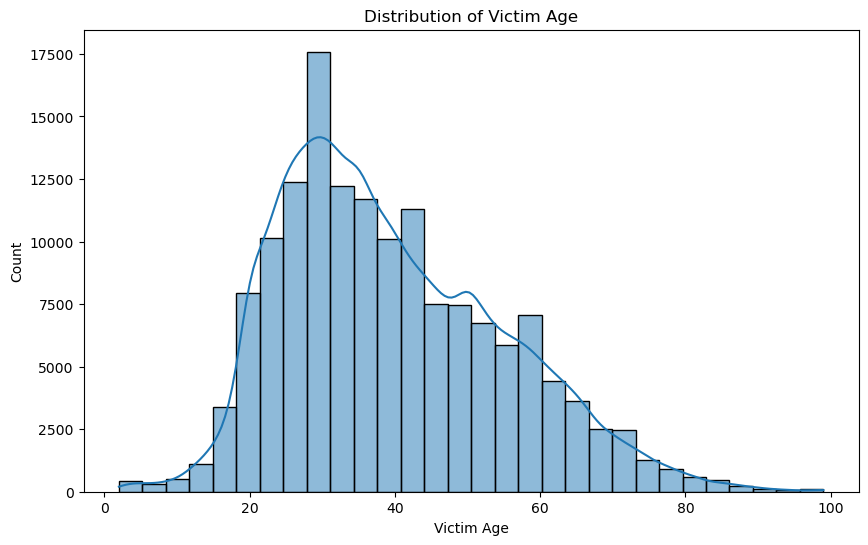

In [265]:
# Distribution of victim age
plt.figure(figsize=(10, 6))
sns.histplot(crime['victim_age'].dropna(), bins=30, kde=True)
plt.title('Distribution of Victim Age')
plt.xlabel('Victim Age')
plt.ylabel('Count')
plt.show()

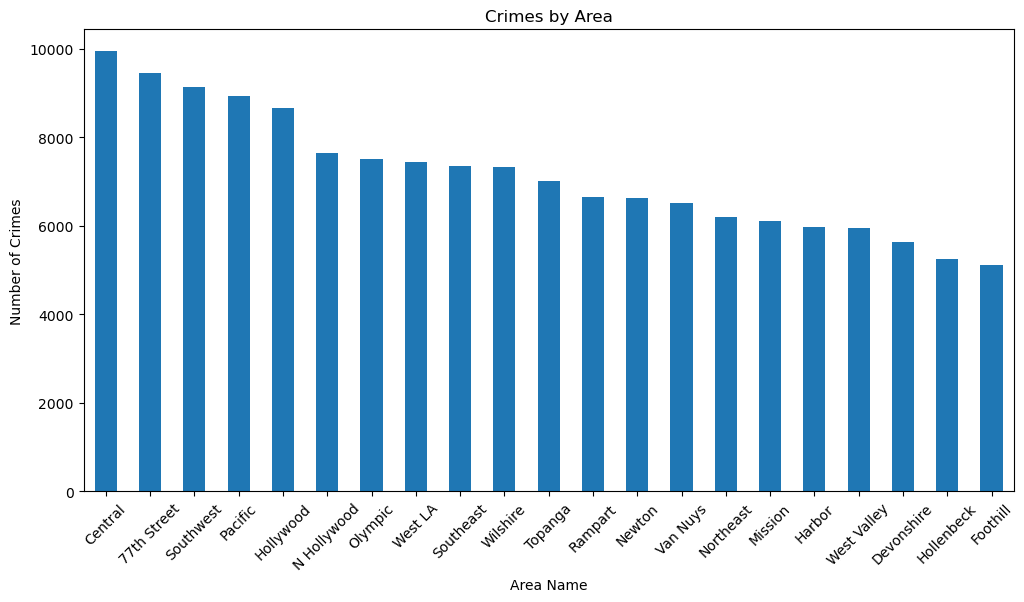

In [266]:
# Distribution of crimes by area
plt.figure(figsize=(12, 6))
crime['area_name'].value_counts().plot(kind='bar')
plt.title('Crimes by Area')
plt.xlabel('Area Name')
plt.ylabel('Number of Crimes')
plt.xticks(rotation=45)
plt.show()

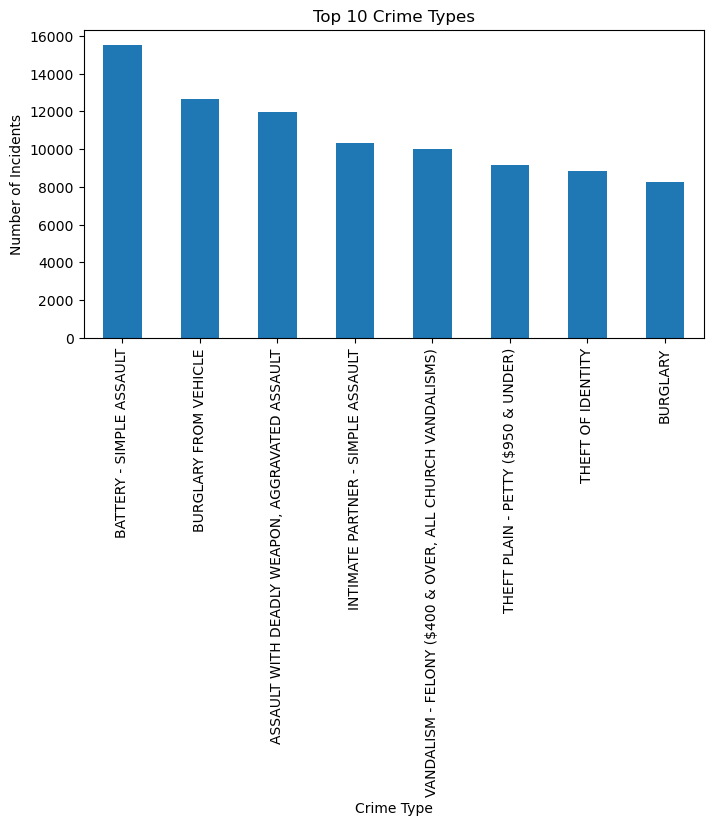

In [268]:
# Top 10 crime types
plt.figure(figsize=(8, 4))
crime['crime_description'].value_counts().head(8).plot(kind='bar')
plt.title('Top 10 Crime Types')
plt.xlabel('Crime Type')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=90)
plt.show()

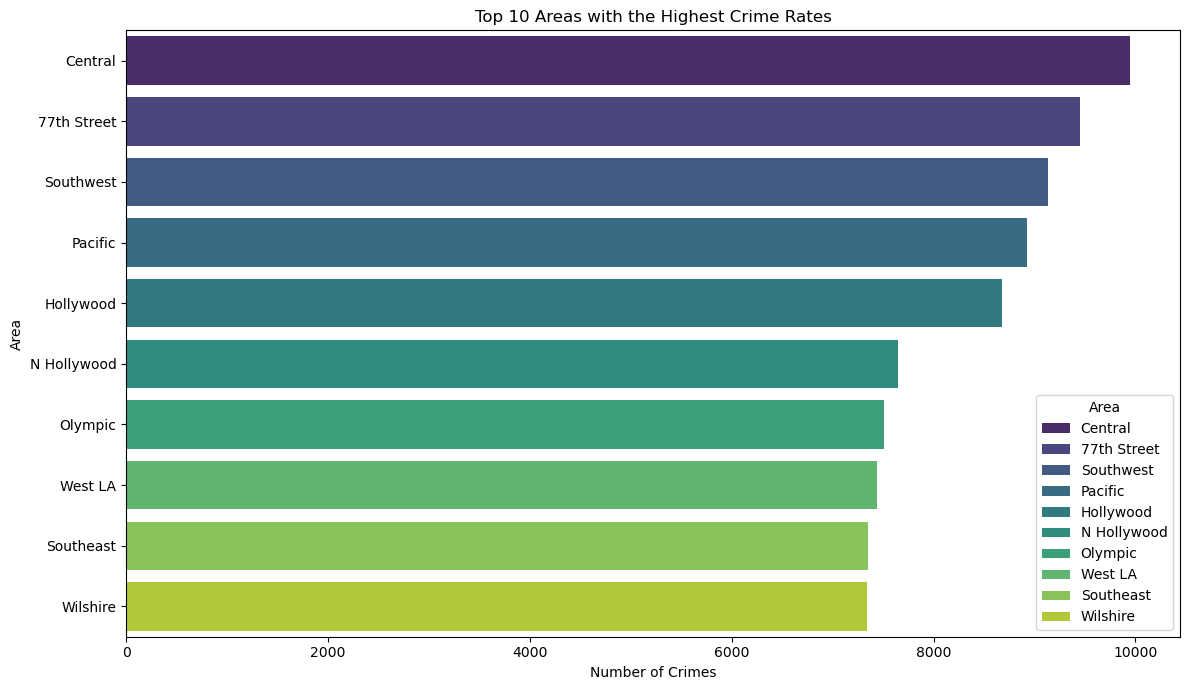

In [269]:
top_areas = crime['area_name'].value_counts().head(10)
top_areas_df = top_areas.reset_index()
top_areas_df.columns = ['Area', 'Crime_Count']

plt.figure(figsize=(12, 7))
sns.barplot(data=top_areas_df, x='Crime_Count', y='Area', hue='Area', palette='viridis', legend=True)
plt.title('Top 10 Areas with the Highest Crime Rates')
plt.xlabel('Number of Crimes')
plt.ylabel('Area')
plt.tight_layout()
plt.show()

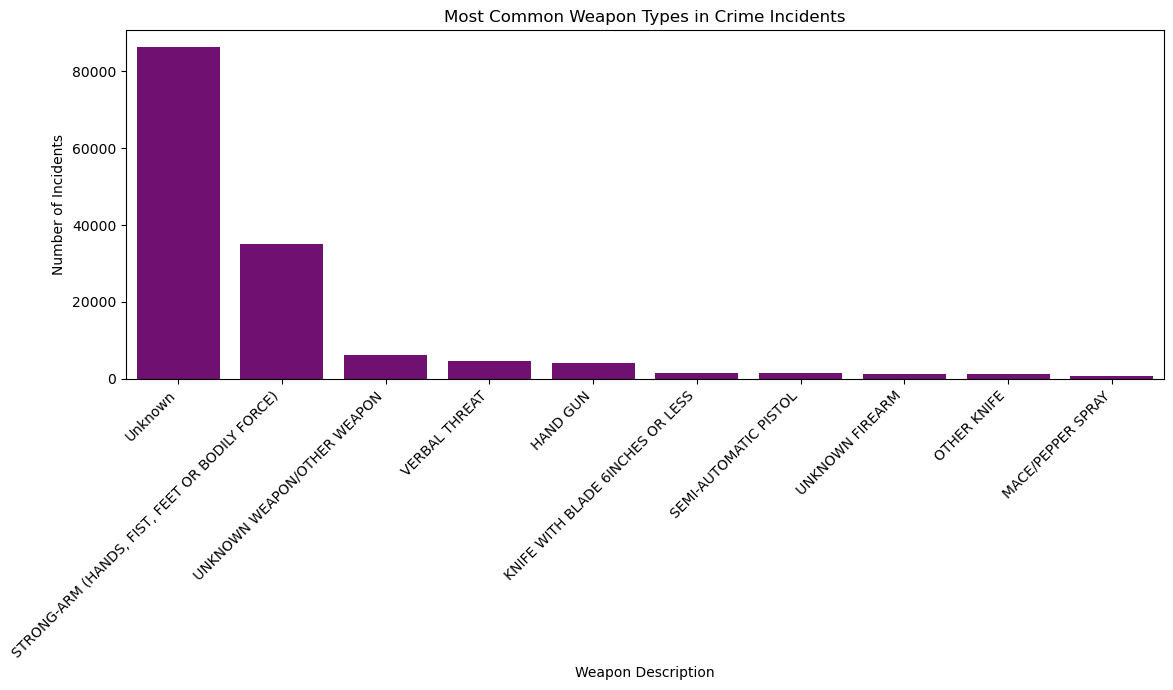

In [271]:
# Most Common Weapon Types
plt.figure(figsize=(12, 7))
top_weapons = crime['weapon_description'].value_counts(dropna=True).head(10)
sns.barplot(x=top_weapons.index, y=top_weapons.values, color='purple')
plt.title('Most Common Weapon Types in Crime Incidents')
plt.xlabel('Weapon Description')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

- Analyze time- and location-based patterns

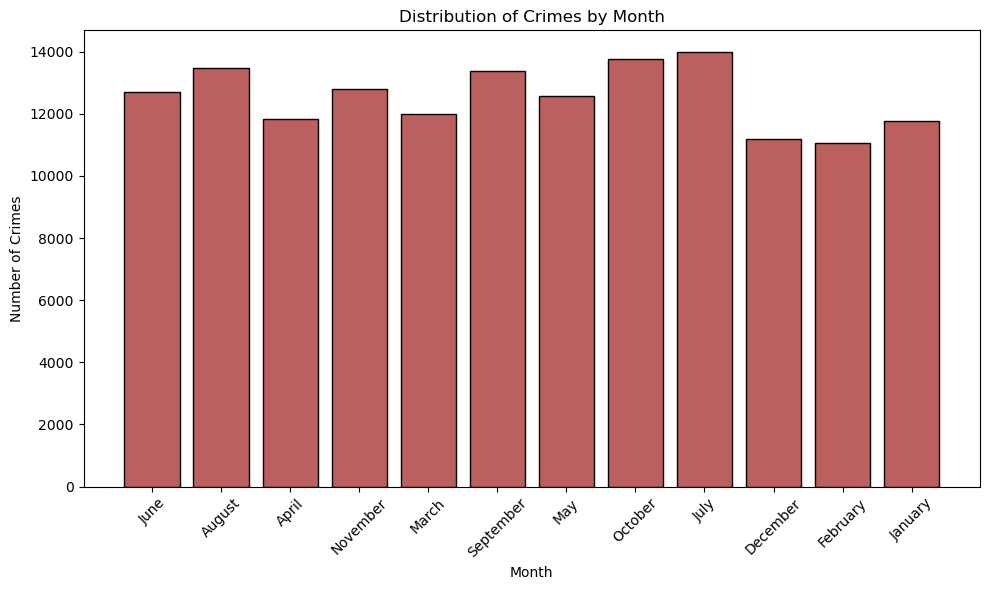

In [276]:
#Crime counts per month
plt.figure(figsize=(10, 6))
sns.histplot(data=crime, x='month_occurred', discrete=True, shrink=0.8, color='brown')
plt.title('Distribution of Crimes by Month')
plt.xlabel('Month')
plt.ylabel('Number of Crimes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

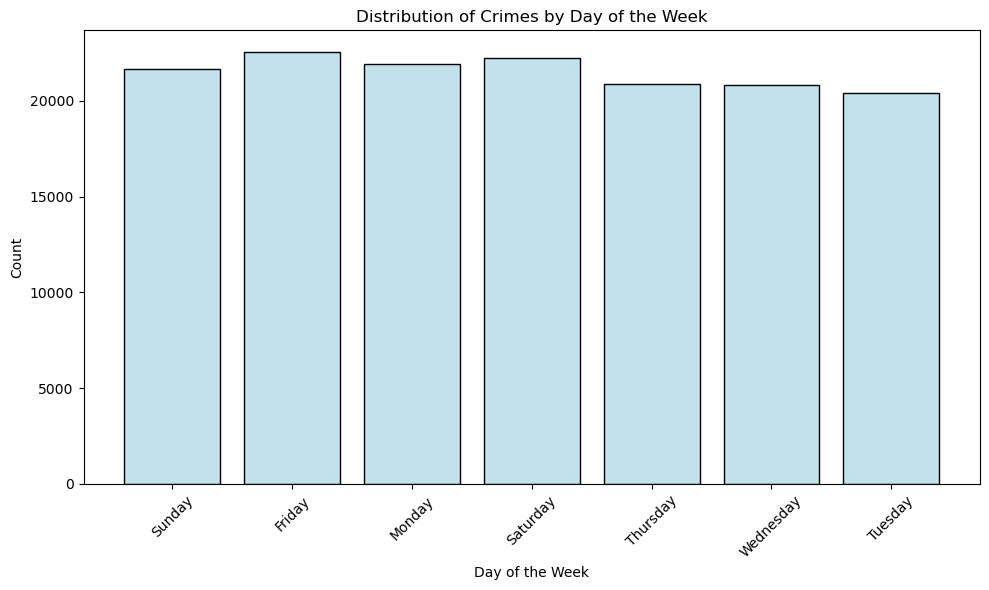

In [278]:
#Crime counts by Day of the Week
plt.figure(figsize=(10, 6))
sns.histplot(data=crime, x='occurred_day_of_week', discrete=True, shrink=0.8, color='lightblue')
plt.title('Distribution of Crimes by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

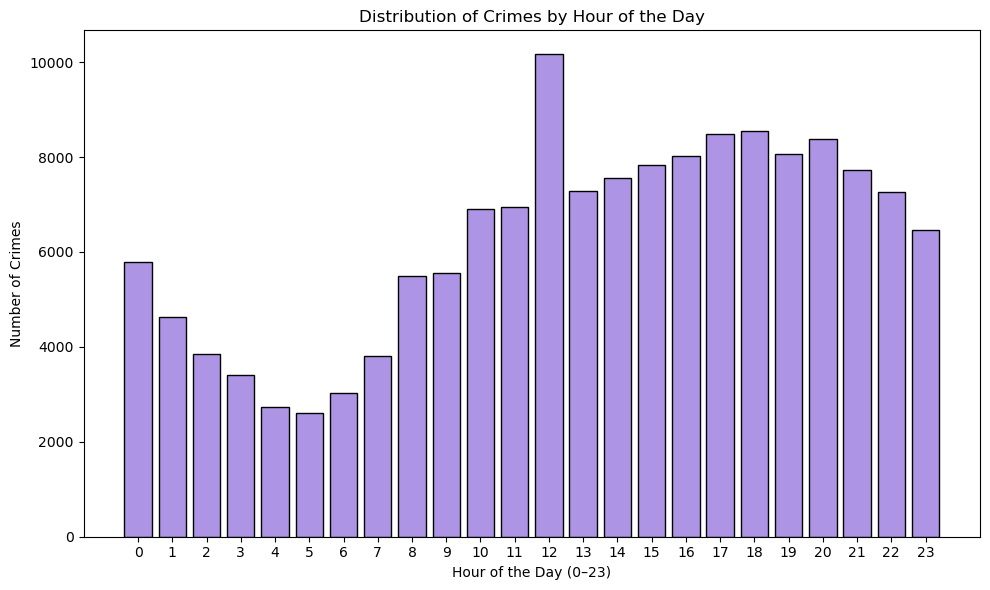

In [280]:
#Crime counts by Hour if the Day
plt.figure(figsize=(10, 6))
sns.histplot(data=crime, x='occurred_hour', bins=24, discrete=True, shrink=0.8, color='mediumpurple')
plt.title('Distribution of Crimes by Hour of the Day')
plt.xlabel('Hour of the Day (0–23)')
plt.ylabel('Number of Crimes')
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

In [282]:
crime = crime[crime['longitude'] != 0]
crime = crime[crime['latitude'] != 0]

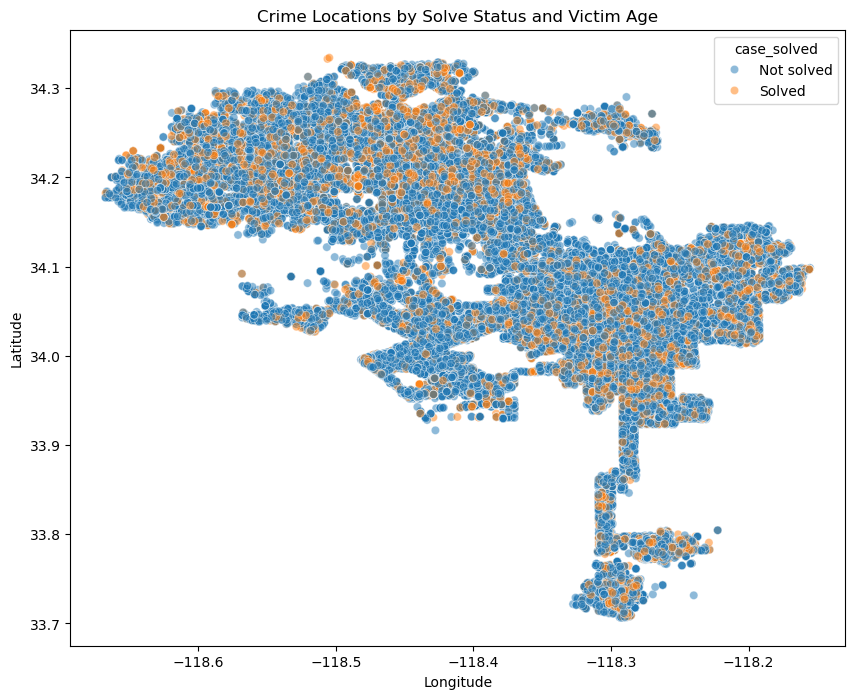

In [284]:
# Scatter plot of crime locations
plt.figure(figsize=(10, 8))
sns.scatterplot(x='longitude', y='latitude', hue='case_solved', data=crime, alpha=0.5)
plt.title('Crime Locations by Solve Status and Victim Age')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

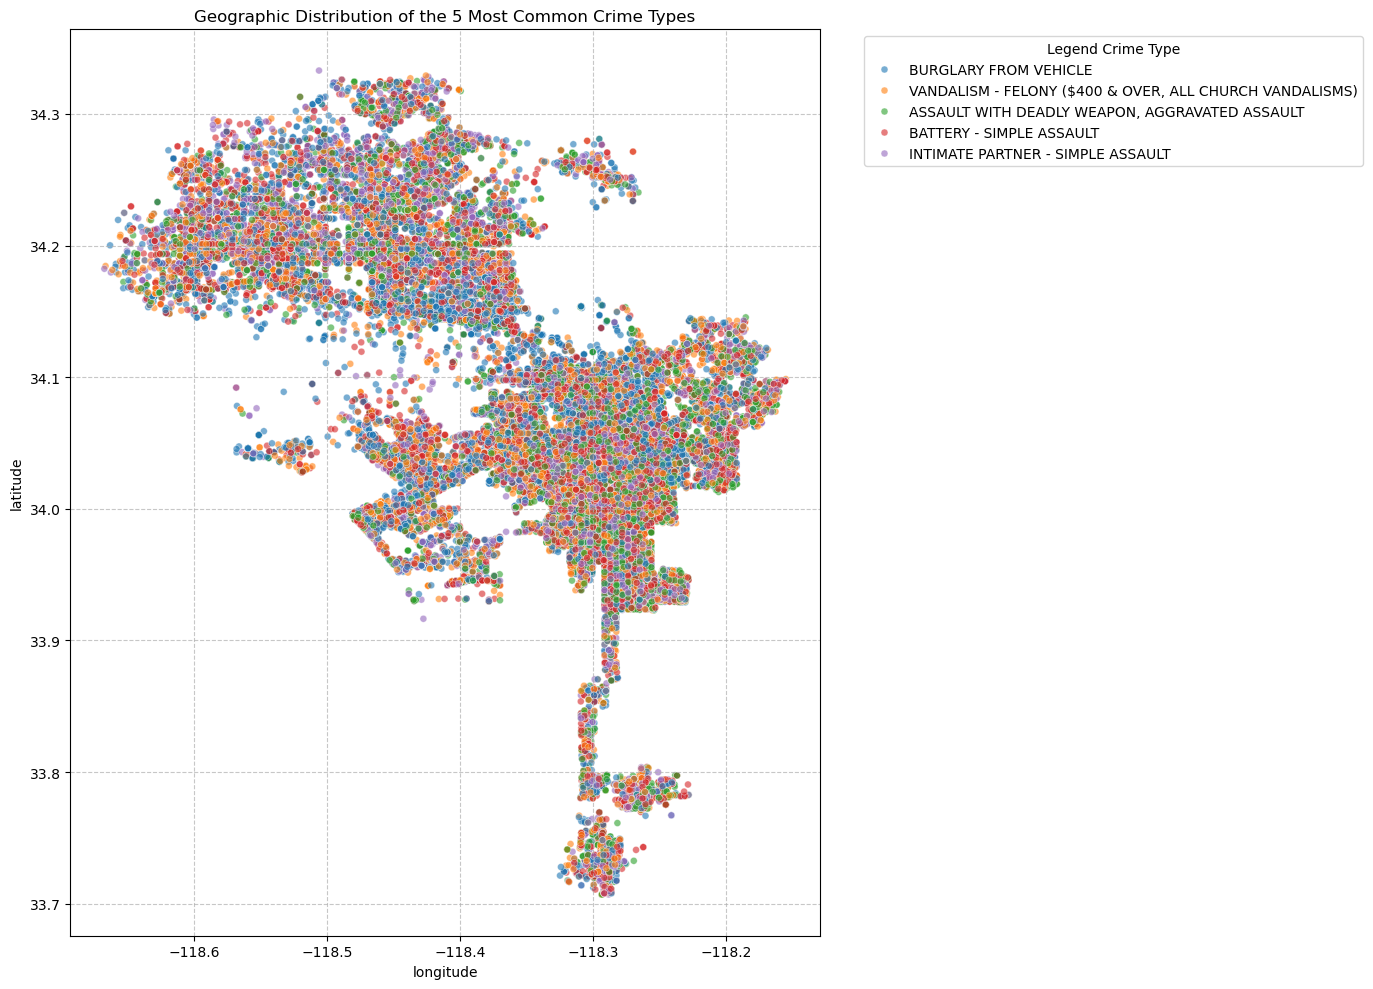

In [285]:
#  Geographic Distribution of the 5 Most Common Crime Types
top_crime_types_for_map = crime['crime_description'].value_counts().head(5).index.tolist()
crime_filtered_for_map = crime[crime['crime_description'].isin(top_crime_types_for_map)].copy()
crime_filtered_for_map.dropna(subset=['latitude', 'longitude'], inplace=True)
plt.figure(figsize=(14, 10))
sns.scatterplot(
    x='longitude',
    y='latitude',
    hue='crime_description',
    data=crime_filtered_for_map,
    s=25, 
    alpha=0.6,
    palette='tab10',
    legend='full')
plt.title('Geographic Distribution of the 5 Most Common Crime Types')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.legend(title='Legend Crime Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

- Explore solve rate by various features

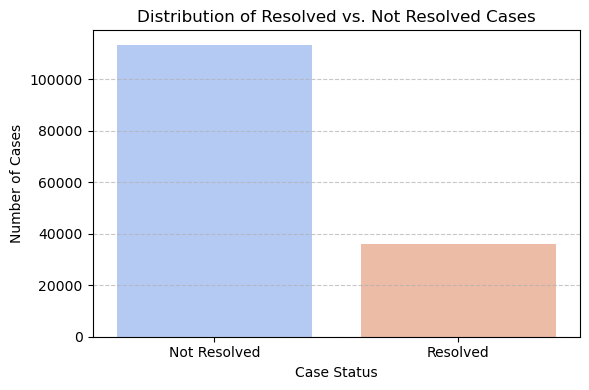

In [289]:
# Solved vs Not Solved
class_counts = crime['case_solved'].value_counts().sort_index()

df_class_counts = class_counts.reset_index()
df_class_counts.columns = ['case_status', 'count']
plt.figure(figsize=(6, 4))
sns.barplot(data=df_class_counts, x='case_status', y='count', hue='case_status', palette='coolwarm', dodge=False, legend=False)
plt.title('Distribution of Resolved vs. Not Resolved Cases')
plt.xlabel('Case Status')
plt.ylabel('Number of Cases')
plt.xticks(ticks=[0, 1], labels=['Not Resolved', 'Resolved'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

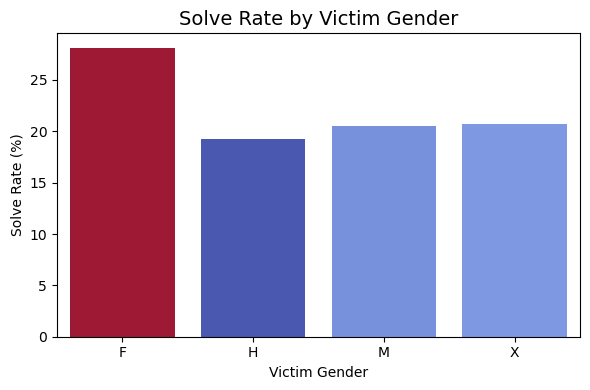

In [291]:
# Solve Rate by Gender
solve_rate_by_gender = (crime.groupby('victim_gender')['case_solved'].value_counts(normalize=True).unstack().fillna(0))
solve_rate_by_gender['Solved'] = solve_rate_by_gender['Solved'] * 100
solve_rate_gender_df = solve_rate_by_gender.reset_index()[['victim_gender', 'Solved']]
plt.figure(figsize=(6, 4))
sns.barplot(data=solve_rate_gender_df, x='victim_gender', y='Solved', hue='Solved', palette='coolwarm', dodge=False, legend=False)
plt.title('Solve Rate by Victim Gender', fontsize=14)
plt.xlabel('Victim Gender')
plt.ylabel('Solve Rate (%)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

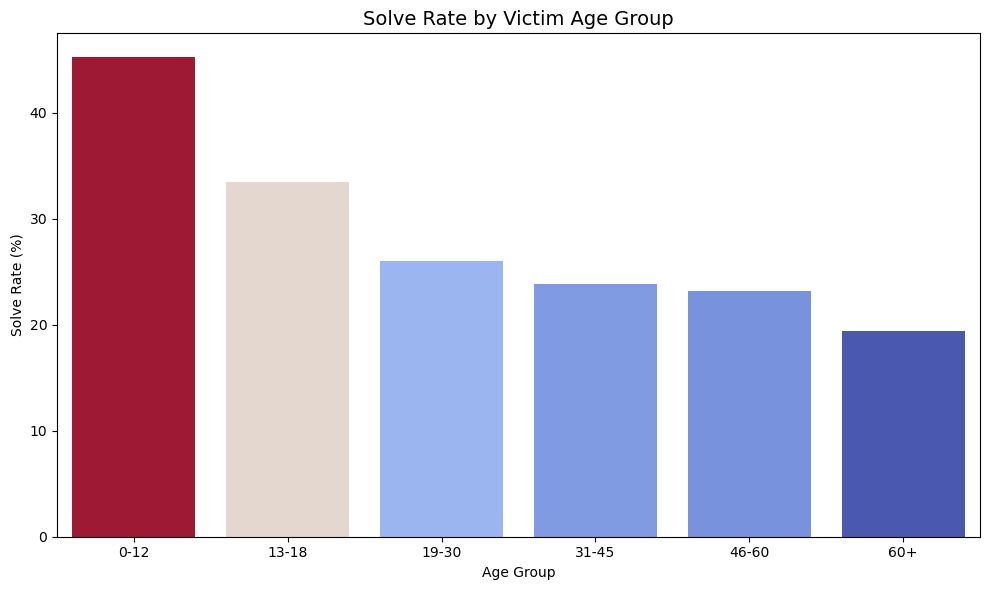

In [293]:
# Solve Rate by Age Group
bins = [0, 12, 18, 30, 45, 60, 100]
labels = ['0-12', '13-18', '19-30', '31-45', '46-60', '60+']
crime['age_group'] = pd.cut(crime['victim_age'], bins=bins, labels=labels, right=False)
solve_rate_by_age_group = (crime.groupby('age_group', observed=False)['case_solved'].value_counts(normalize=True).unstack().fillna(0))
solve_rate_by_age_group['Solved'] = solve_rate_by_age_group['Solved'] * 100
solve_rate_age_df = solve_rate_by_age_group.reset_index()[['age_group', 'Solved']]
plt.figure(figsize=(10, 6))
sns.barplot(data=solve_rate_age_df, x='age_group', y='Solved', hue='Solved', palette='coolwarm', dodge=False, legend=False)
plt.title('Solve Rate by Victim Age Group', fontsize=14)
plt.xlabel('Age Group')
plt.ylabel('Solve Rate (%)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

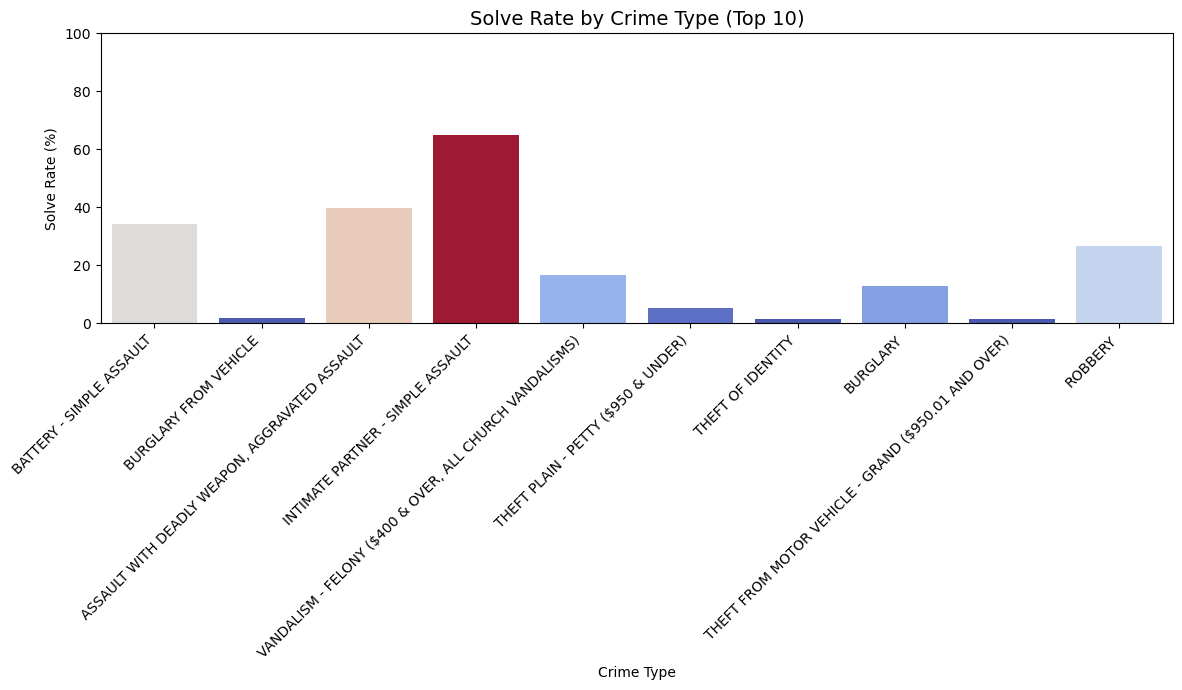

In [295]:
# Solve Rate by Crime Type
solve_rate_by_crime = (crime.groupby('crime_description')['case_solved'].value_counts(normalize=True).unstack().fillna(0))
solve_rate_by_crime['Solved'] = solve_rate_by_crime['Solved'] * 100
top_crimes = crime['crime_description'].value_counts().head(10).index
solve_rate_top10 = solve_rate_by_crime.loc[top_crimes].reset_index()
solve_rate_top10 = solve_rate_top10[['crime_description', 'Solved']]
plt.figure(figsize=(12, 7))
sns.barplot(data=solve_rate_top10, x='crime_description', y='Solved',hue='Solved', palette='coolwarm',dodge=False, legend=False)
plt.title('Solve Rate by Crime Type (Top 10)', fontsize=14)
plt.xlabel('Crime Type')
plt.ylabel('Solve Rate (%)')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

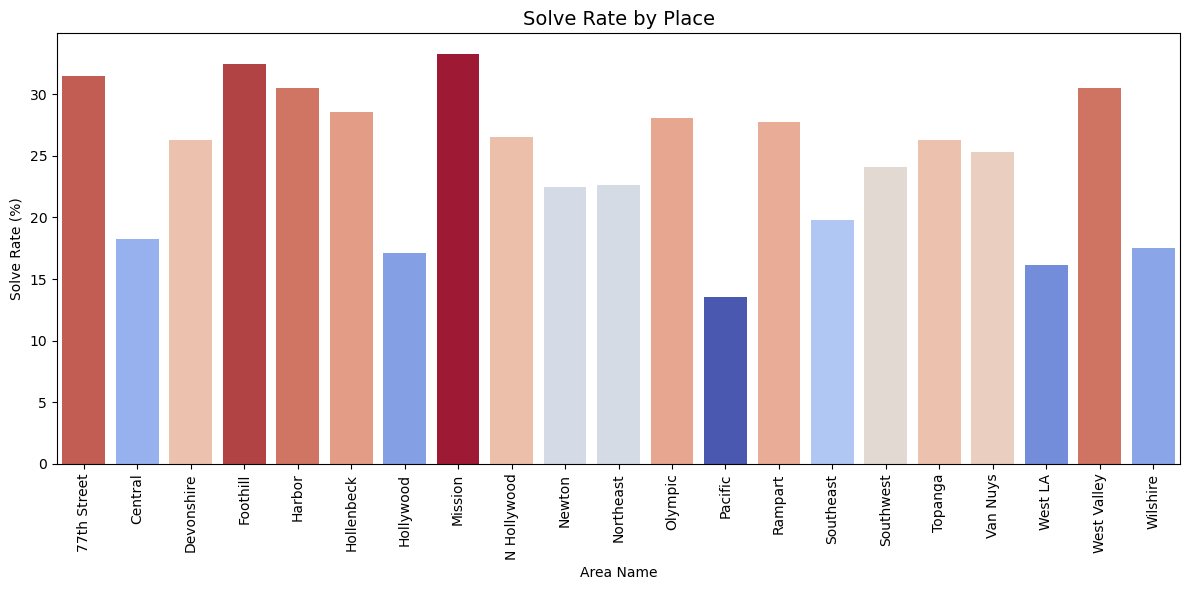

In [297]:
# Solve Rate by Place
solve_rate_by_area = (crime.groupby('area_name')['case_solved'].value_counts(normalize=True).unstack().fillna(0))
solve_rate_by_area['Solved'] = solve_rate_by_area['Solved'] * 100
solve_rate_area_df = solve_rate_by_area.reset_index()[['area_name', 'Solved']]
plt.figure(figsize=(12, 6))
sns.barplot(data=solve_rate_area_df, x='area_name', y='Solved', hue='Solved', palette='coolwarm',dodge=False, legend=False)
plt.title('Solve Rate by Place', fontsize=14)
plt.xlabel('Area Name')
plt.ylabel('Solve Rate (%)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

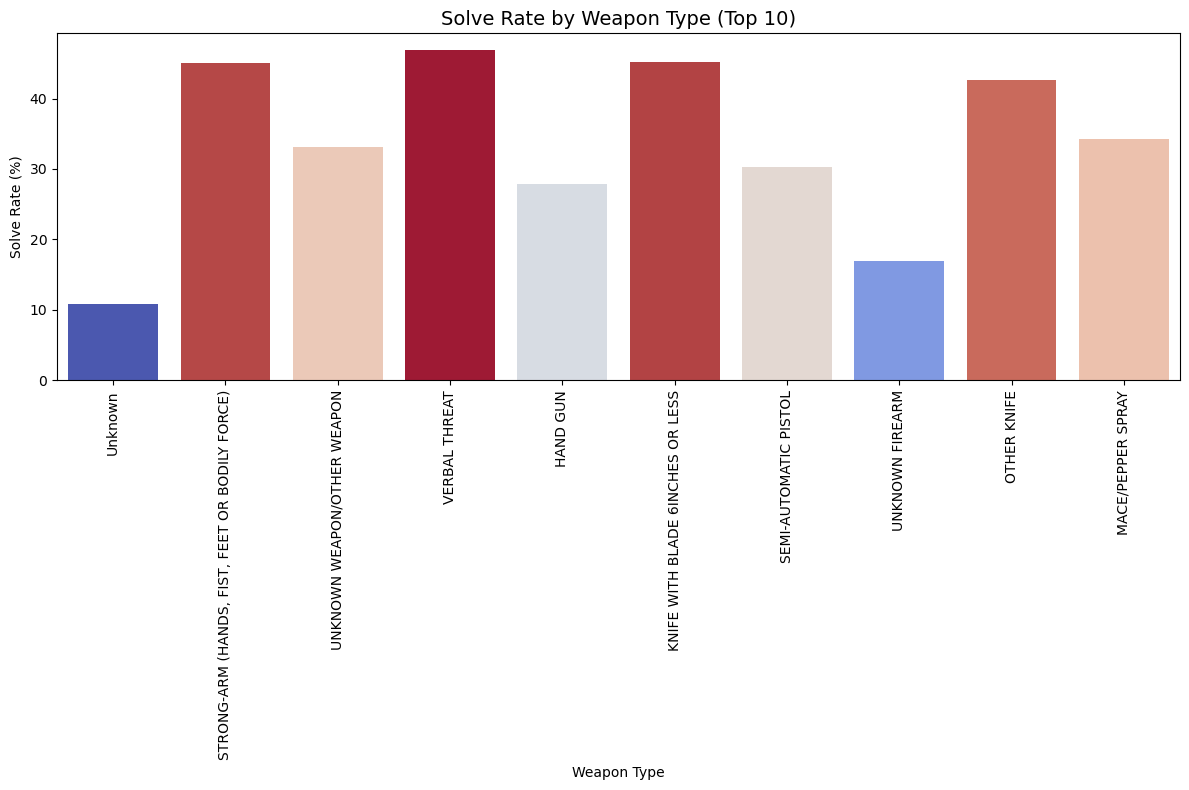

In [298]:
# Solve Rate by Weapon Type
solve_rate_by_weapon = (crime.groupby('weapon_description')['case_solved'].value_counts(normalize=True).unstack().fillna(0))
solve_rate_by_weapon['Solved'] = solve_rate_by_weapon['Solved'] * 100
top_weapons = crime['weapon_description'].value_counts().head(10).index
solve_rate_top_weapons = solve_rate_by_weapon.loc[top_weapons].reset_index()[['weapon_description', 'Solved']]
plt.figure(figsize=(12, 8))
sns.barplot(data=solve_rate_top_weapons, x='weapon_description', y='Solved', hue='Solved', palette='coolwarm',dodge=False, legend=False)
plt.title('Solve Rate by Weapon Type (Top 10)', fontsize=14)
plt.xlabel('Weapon Type')
plt.ylabel('Solve Rate (%)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## 3. Model Building

## LOGISTIC REGRESSION MODEL

In [302]:
crime.shape

(149402, 23)

In [304]:
# Encode the target variable 'case_solved'
# 'Not solved' -> 0, 'Solved' -> 1
crime['case_solved'] = crime['case_solved'].map({'Not solved': 0, 'Solved': 1})
# Drop any rows where 'case_solved' became NaN after mapping (e.g., due to unexpected values)
crime.dropna(subset=['case_solved'], inplace=True)
# Ensure the target column is explicitly cast to integer type
crime['case_solved'] = crime['case_solved'].astype(int)
print("Target variable 'case_solved' encoded and converted to integer type.")

Target variable 'case_solved' encoded and converted to integer type.


In [67]:
crime.shape

(149402, 23)

In [312]:
# Selecting features for build the model:
selected_features = [
    'area_name', 'victim_age', 'victim_gender', 'victim_ethnicity',
    'premise_description', 'year_occurred',
    'month_occurred', 'occurred_day_of_week', 'occurred_hour',
    'weapon_description', 'crime_description'
]
X = crime[selected_features]
y = crime['case_solved']
print(f"\nFeatures selected: {selected_features}")
# Identify numerical and categorical columns for preprocessing
numerical_features = ['victim_age', 'year_occurred', 'occurred_hour']
categorical_features = [
    'area_name', 'victim_gender', 'victim_ethnicity', 'premise_description',
    'month_occurred', 'occurred_day_of_week', 'weapon_description', 'crime_description'
]


Features selected: ['area_name', 'victim_age', 'victim_gender', 'victim_ethnicity', 'premise_description', 'year_occurred', 'month_occurred', 'occurred_day_of_week', 'occurred_hour', 'weapon_description', 'crime_description']


In [314]:
#Defining Preprocessing Pipelines:
# Numerical transformer: Impute with median, then scale
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
# Categorical transformer: Impute with most frequent, then OneHotEncode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # handle_unknown='ignore' to handle unseen categories
])
# Create a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])
print("\nPreprocessing pipelines defined.")


Preprocessing pipelines defined.


In [316]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nData split into training and testing sets. Train size: {len(X_train)}, Test size: {len(X_test)}")
print(f"Class distribution in original data:\n{y.value_counts(normalize=True)}")
print(f"Class distribution in training data:\n{y_train.value_counts(normalize=True)}")
print(f"Class distribution in test data:\n{y_test.value_counts(normalize=True)}")
training_data_sample_ratio = 0.5 

if training_data_sample_ratio < 1.0:
    print(f"\nSampling training data to {training_data_sample_ratio*100}% of its original size...")
    # Sample the training data
    # Use stratify=y_train to maintain class distribution in the sampled subset
    X_train, _, y_train, _ = train_test_split(
        X_train, y_train, train_size=training_data_sample_ratio, random_state=42, stratify=y_train
    )
    print(f"New training data size after sampling: {len(X_train)} samples.")
    print(f"Class distribution in sampled training data:\n{y_train.value_counts(normalize=True)}")
else:
    print("\nUsing full training dataset (no sampling applied).")

print("\nApplying preprocessing to training and test data...")
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
print("Data preprocessing complete.")


Data split into training and testing sets. Train size: 119521, Test size: 29881
Class distribution in original data:
case_solved
0    0.758611
1    0.241389
Name: proportion, dtype: float64
Class distribution in training data:
case_solved
0    0.758611
1    0.241389
Name: proportion, dtype: float64
Class distribution in test data:
case_solved
0    0.758609
1    0.241391
Name: proportion, dtype: float64

Sampling training data to 50.0% of its original size...
New training data size after sampling: 59760 samples.
Class distribution in sampled training data:
case_solved
0    0.758618
1    0.241382
Name: proportion, dtype: float64

Applying preprocessing to training and test data...
Data preprocessing complete.


In [318]:
# Model Building and Training
# Logistic Regression Model
print("\n--- Training Logistic Regression Model ---")
lr_model = LogisticRegression(solver='liblinear', random_state=42, max_iter=1000)
lr_model.fit(X_train_processed, y_train)
print("Logistic Regression model trained.")


--- Training Logistic Regression Model ---
Logistic Regression model trained.


In [320]:
# Evaluate Logistic Regression ---
print("\n--- Evaluating Logistic Regression Model ---")

# Predictions and probabilities are made on the already preprocessed X_test
lr_predictions = lr_model.predict(X_test_processed)
lr_probabilities = lr_model.predict_proba(X_test_processed)[:, 1]  # Probabilities for the positive class (1)

print("\nClassification Report for Logistic Regression:")
print(classification_report(y_test, lr_predictions))
print("\nConfusion Matrix for Logistic Regression:")
lr_cm = confusion_matrix(y_test, lr_predictions)
print(lr_cm)


--- Evaluating Logistic Regression Model ---

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.84      0.92      0.88     22668
           1       0.64      0.46      0.54      7213

    accuracy                           0.81     29881
   macro avg       0.74      0.69      0.71     29881
weighted avg       0.79      0.81      0.80     29881


Confusion Matrix for Logistic Regression:
[[20831  1837]
 [ 3890  3323]]


Logistic Regression AUC-ROC Score: 0.8399


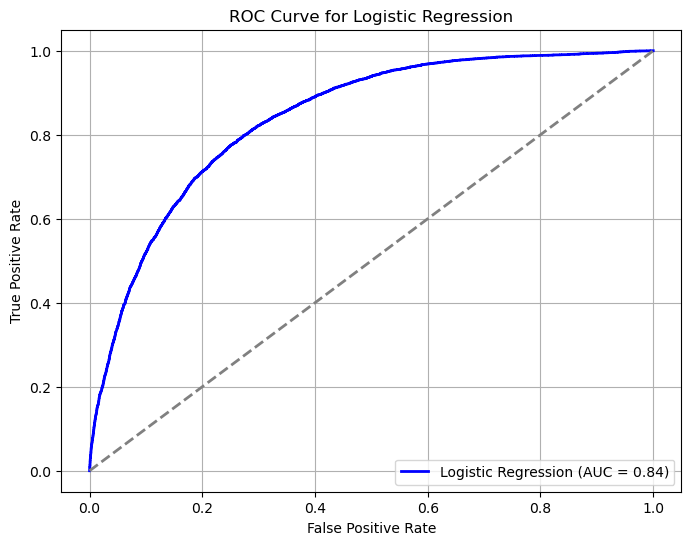

In [322]:
# Calculate AUC-ROC for Logistic Regression
lr_auc = roc_auc_score(y_test, lr_probabilities)
print(f"Logistic Regression AUC-ROC Score: {lr_auc:.4f}")

# Plot the ROC curve for Logistic Regression
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probabilities)
plt.figure(figsize=(8, 6))
plt.plot(lr_fpr, lr_tpr, color='blue', lw=2, label=f'Logistic Regression (AUC = {lr_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## RANDOM FOREST MODEL

In [325]:
print("\nTraining lightweight Random Forest model...")
rf_light_model = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, random_state=42, n_jobs=1)


Training lightweight Random Forest model...


In [327]:
X_train_small = X_train_processed
y_train_small = y_train
rf_light_model.fit(X_train_small, y_train_small)

RandomForestClassifier(max_depth=10, min_samples_split=5, n_jobs=1,
                       random_state=42)

In [328]:
print("\nEvaluating lightweight model...")
X_test_small = X_test_processed
y_test_small = y_test
rf_preds = rf_light_model.predict(X_test_small)
rf_probs = rf_light_model.predict_proba(X_test_small)[:, 1]
print("\nClassification Report:")
print(classification_report(y_test_small, rf_preds))


Evaluating lightweight model...

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.99      0.87     22668
           1       0.75      0.09      0.15      7213

    accuracy                           0.77     29881
   macro avg       0.76      0.54      0.51     29881
weighted avg       0.77      0.77      0.70     29881




Confusion Matrix:
[[22464   204]
 [ 6590   623]]

AUC-ROC Score: 0.8196


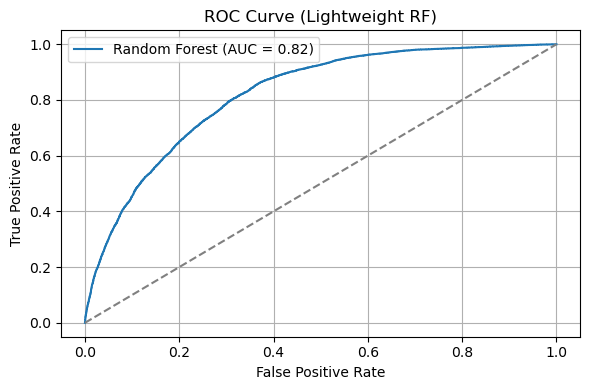

In [331]:
# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_small, rf_preds))

# AUC-ROC
rf_auc = roc_auc_score(y_test_small, rf_probs)
print(f"\nAUC-ROC Score: {rf_auc:.4f}")

#  ROC Curve
fpr, tpr, _ = roc_curve(y_test_small, rf_probs)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {rf_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Lightweight RF)')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()